In [1]:
# Required Packages
import numpy as np
import pandas as pd
import wfdb
import pywt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(42)

# Path to MIT-BIH data
data = 'mitdb/'

# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

# Abnormal & Normal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']
normal = ['N']

# Wavelet denoising
def wavelet_denoising(signal, wavelet='db6', level=1):
    coeff = pywt.wavedec(signal, wavelet, mode='per')
    sigma = np.median(np.abs(coeff[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeff[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:]]
    return pywt.waverec(coeff, wavelet, mode='per')

# Apply denoising to dataset
def denoise_ecg_signals(signals):
    return np.array([wavelet_denoising(signal) for signal in signals])

# Load ECG signal & annotation
def load_ecg(file):
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    p_signal = record.p_signal[:, 0]  # First channel
    return p_signal, annotation.symbol, annotation.sample

# Extract X (ECG segment), Y (label), sym (beat symbol)
def build_XY(p_signal, df_ann, num_cols, abnormal):
    num_rows = len(df_ann)
    X = np.zeros((num_rows, num_cols))
    Y = np.empty((num_rows, 1), dtype='<U2')  # for string symbols
    sym = []
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values, df_ann.atr_sym.values):
        left = max(0, atr_sample - num_sec * fs)
        right = min(len(p_signal), atr_sample + num_sec * fs)
        x = p_signal[left:right]
        if len(x) == num_cols:
            X[max_row, :] = x
            Y[max_row, :] = atr_sym  # keep the actual beat symbol
            sym.append(atr_sym)
            max_row += 1

    return X[:max_row, :], Y[:max_row, :], sym

# Create dataset from all patients
def make_dataset(patients, num_sec, fs, abnormal):
    num_cols = 2 * num_sec * fs
    X_all = []
    Y_all = []
    sym_all = []

    for pt in patients:
        file = data + pt
        p_signal, atr_sym, atr_sample = load_ecg(file)
        df_ann = pd.DataFrame({'atr_sym': atr_sym, 'atr_sample': atr_sample})
        df_ann = df_ann[df_ann.atr_sym.isin(abnormal + ['N'])]
        X, Y, sym = build_XY(p_signal, df_ann, num_cols, abnormal)
        if len(X) > 0:
            X_all.append(X)
            Y_all.append(Y)
            sym_all += sym

    X_all = np.vstack(X_all)
    Y_all = np.vstack(Y_all)
    return X_all, Y_all, sym_all

# Parameters
num_sec = 3
fs = 360

# Prepare dataset
X_all, Y_all, sym_all = make_dataset(patients, num_sec, fs, abnormal)

# Denoise
X_all_denoised = denoise_ecg_signals(X_all)

# Normalize
scaler = MinMaxScaler()
X_all_normalized = scaler.fit_transform(X_all_denoised)

In [2]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np

# Encode labels
ECG_classes = ['N', 'L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(ECG_classes)

Y_encoded = label_encoder.fit_transform(Y_all.ravel())

print("Original class distribution:", Counter(Y_encoded))

# Step 1: Determine valid classes (with at least 10 samples)
threshold = 10
class_counts = Counter(Y_encoded)
valid_classes = [cls for cls, count in class_counts.items() if count >= threshold]

# Step 2: Filter valid class data
mask = np.isin(Y_encoded, valid_classes)
X_filtered = X_all_normalized[mask]
Y_filtered = Y_encoded[mask]

print("Original distribution:", Counter(Y_filtered))

# Step 3: Apply RU only to class 6 (e.g., reduce to 8000 if more than that)
target_samples_per_class = 8000
sampling_strategy = {6: target_samples_per_class}

# Apply RU (leaves other classes unchanged)
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, Y_resampled = rus.fit_resample(X_filtered, Y_filtered)

# Step 4: Add class 8 (with 2 samples) back
class_8_mask = (Y_encoded == 8)
X_class8 = X_all_normalized[class_8_mask]
Y_class8 = Y_encoded[class_8_mask]

# Merge with previously resampled data
X_final = np.vstack([X_resampled, X_class8])
Y_final = np.hstack([Y_resampled, Y_class8])

# Final check
final_counts = Counter(Y_final)
print("Final class distribution:", final_counts)
print("Final X shape:", X_final.shape)
print("Final Y shape:", Y_final.shape)


Original class distribution: Counter({6: 74795, 5: 8052, 7: 7235, 9: 7113, 0: 6999, 1: 2536, 12: 982, 3: 801, 13: 229, 10: 150, 2: 106, 4: 83, 11: 16, 8: 2})
Original distribution: Counter({6: 74795, 5: 8052, 7: 7235, 9: 7113, 0: 6999, 1: 2536, 12: 982, 3: 801, 13: 229, 10: 150, 2: 106, 4: 83, 11: 16})
Final class distribution: Counter({5: 8052, 6: 8000, 7: 7235, 9: 7113, 0: 6999, 1: 2536, 12: 982, 3: 801, 13: 229, 10: 150, 2: 106, 4: 83, 11: 16, 8: 2})
Final X shape: (42304, 2160)
Final Y shape: (42304,)


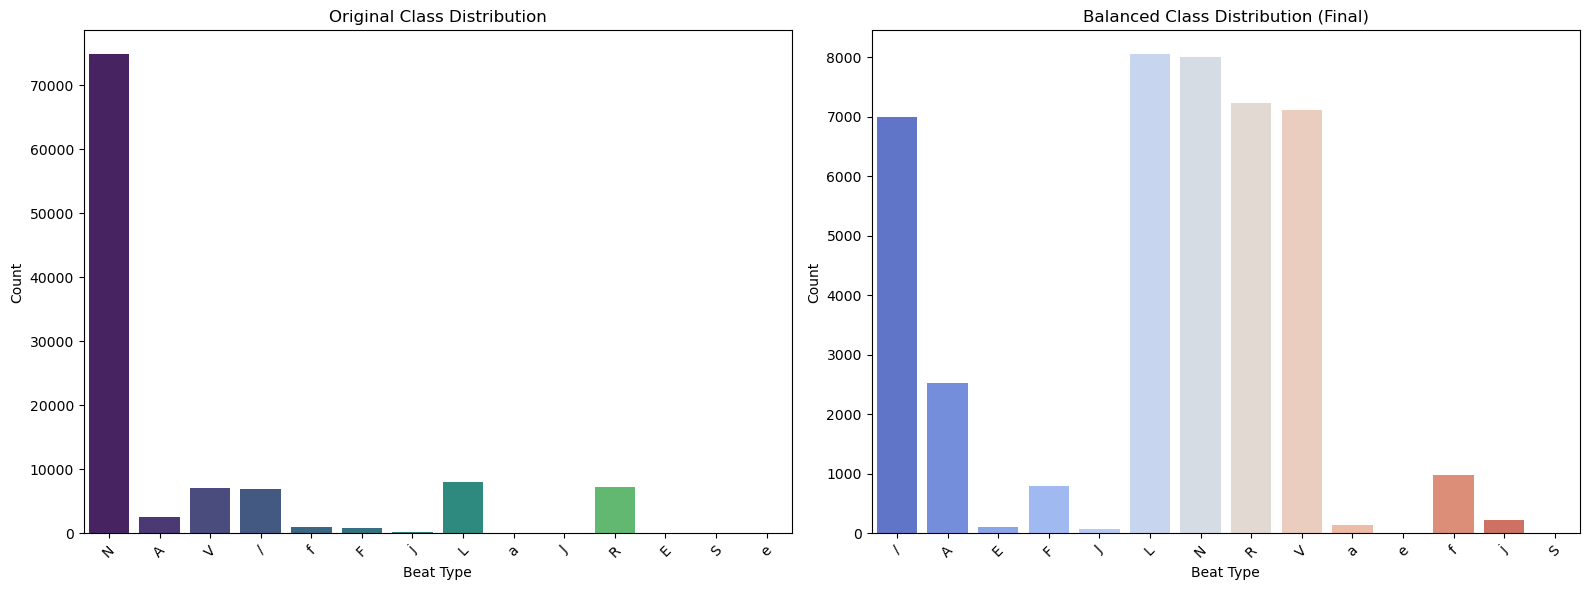

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Encode labels
ECG_classes = ['N', 'L', 'R', 'V', '/', 'A', 'f', 'F', 'j', 'a', 'E', 'J', 'e', 'S']

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(ECG_classes)

Y_encoded = label_encoder.fit_transform(Y_all.ravel())

# --- Original distribution ---
original_counts = Counter(Y_encoded)
original_labels = label_encoder.inverse_transform(list(original_counts.keys()))
original_freqs = list(original_counts.values())

# --- After final resampling (including class 8) ---
resampled_counts = Counter(Y_final)  
resampled_labels = label_encoder.inverse_transform(list(resampled_counts.keys()))
resampled_freqs = list(resampled_counts.values())

# --- Plotting ---
plt.figure(figsize=(16, 6))

# Plot original
plt.subplot(1, 2, 1)
sns.barplot(x=original_labels, y=original_freqs, palette='viridis')
plt.title('Original Class Distribution')
plt.xlabel('Beat Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot resampled
plt.subplot(1, 2, 2)
sns.barplot(x=resampled_labels, y=resampled_freqs, palette='coolwarm')
plt.title('Balanced Class Distribution (Final)')
plt.xlabel('Beat Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [4]:
from collections import Counter

# Count per class
resampled_counts = Counter(Y_final)
print("Resampled class distribution:")
for label, count in sorted(resampled_counts.items()):
    print(f"Class {label}: {count} samples")

# Total count
total_samples = sum(resampled_counts.values())
print(f"\n✅ Total resampled samples: {total_samples}")

Resampled class distribution:
Class 0: 6999 samples
Class 1: 2536 samples
Class 2: 106 samples
Class 3: 801 samples
Class 4: 83 samples
Class 5: 8052 samples
Class 6: 8000 samples
Class 7: 7235 samples
Class 8: 2 samples
Class 9: 7113 samples
Class 10: 150 samples
Class 11: 16 samples
Class 12: 982 samples
Class 13: 229 samples

✅ Total resampled samples: 42304


In [5]:
from sklearn.model_selection import train_test_split

# X_resampled, Y_resampled already from your pipeline
X_train, X_test, y_train, y_test = train_test_split(X_final, Y_final, test_size=0.2, random_state=42, stratify=Y_final)


In [6]:
total_samples = X_final.shape[0]
train_samples = X_train.shape[0]
test_samples = X_test.shape[0]

print(f"Total samples: {total_samples}")
print(f"Training samples: {train_samples} ({train_samples / total_samples:.2%})")
print(f"Testing samples: {test_samples} ({test_samples / total_samples:.2%})")

Total samples: 42304
Training samples: 33843 (80.00%)
Testing samples: 8461 (20.00%)


In [7]:
from tensorflow.keras.utils import to_categorical

num_classes = np.max(Y_resampled) + 1  

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Add channel dimension for CNN: (samples, time_steps, channels)
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2025-05-08 21:58:28.955150: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-08 21:58:28.955337: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-08 21:58:28.955348: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-08 21:58:28.955504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-08 21:58:28.955518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2154, 64)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1077, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1073, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 536, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 534, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 267, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 68352)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,749,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,891,150 (33.92 MB)

 Trainable params: 8,891,150 (33.92 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import time
# Start timer
start_time = time.time()

history = model.fit(
    X_train_cnn, y_train_cat,
    epochs=15,
    batch_size=128,
    validation_data=(X_test_cnn, y_test_cat)
)

# End timer
end_time = time.time()

# Total training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/15


2025-05-08 21:58:46.208858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


265/265 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.2130 - loss: 2.0417 - val_accuracy: 0.6854 - val_loss: 0.9945
Epoch 2/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.6222 - loss: 1.3711 - val_accuracy: 0.8427 - val_loss: 0.5960
Epoch 3/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.7345 - loss: 1.0566 - val_accuracy: 0.8674 - val_loss: 0.5594
Epoch 4/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.7507 - loss: 1.0253 - val_accuracy: 0.8921 - val_loss: 0.4974
Epoch 5/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.7800 - loss: 0.9286 - val_accuracy: 0.9002 - val_loss: 0.4978
Epoch 6/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.7856 - loss: 0.9197 - val_accuracy: 0.8968 - val_loss: 0.4536
Epoch 7/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.8018 - loss: 0.8839 - val_accuracy: 0.9059 - val_loss: 0.4920
Epoch 8/15
265/265 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.8039 - loss: 0.9263 - val_accurac

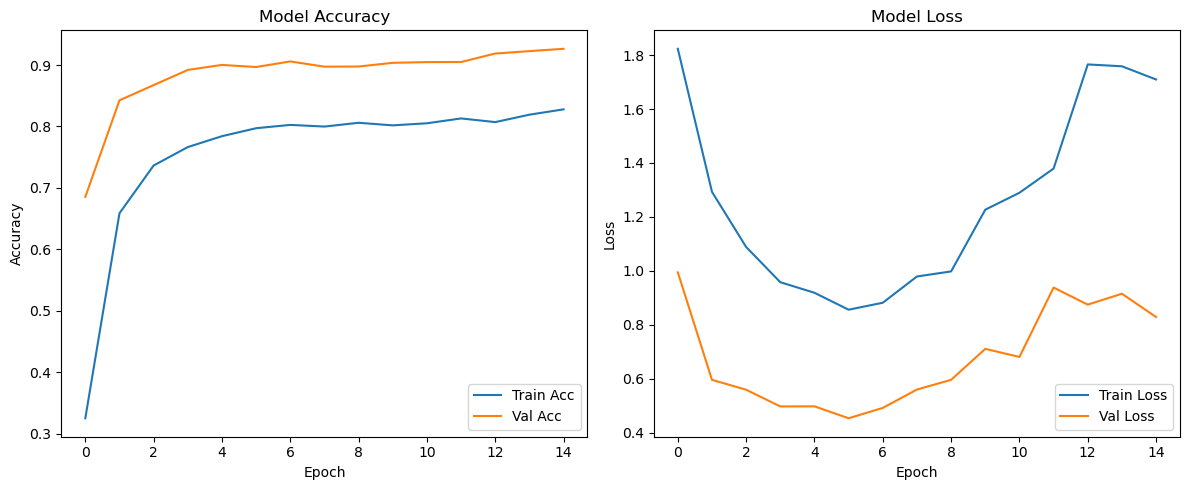

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
y_pred_prob = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n📊 Evaluation Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

📊 Evaluation Metrics:
Accuracy  : 0.9265
Precision : 0.6902
Recall    : 0.6085
F1-score  : 0.6349



Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9837    0.9929    0.9883      1400
           1     0.9044    0.8028    0.8506       507
           2     1.0000    0.5238    0.6875        21
           3     0.6606    0.6813    0.6708       160
           4     0.0000    0.0000    0.0000        17
           5     0.9490    0.9597    0.9543      1611
           6     0.9044    0.8812    0.8927      1600
           7     0.9807    0.9820    0.9814      1447
           9     0.8645    0.9684    0.9135      1423
          10     0.0000    0.0000    0.0000        30
          11     0.0000    0.0000    0.0000         3
          12     0.8830    0.7704    0.8229       196
          13     0.8421    0.3478    0.4923        46

    accuracy                         0.9265      8461
   macro avg     0.6902    0.6085    0.6349      8461
weighted avg     0.9218    0.9265    0.9226      8461



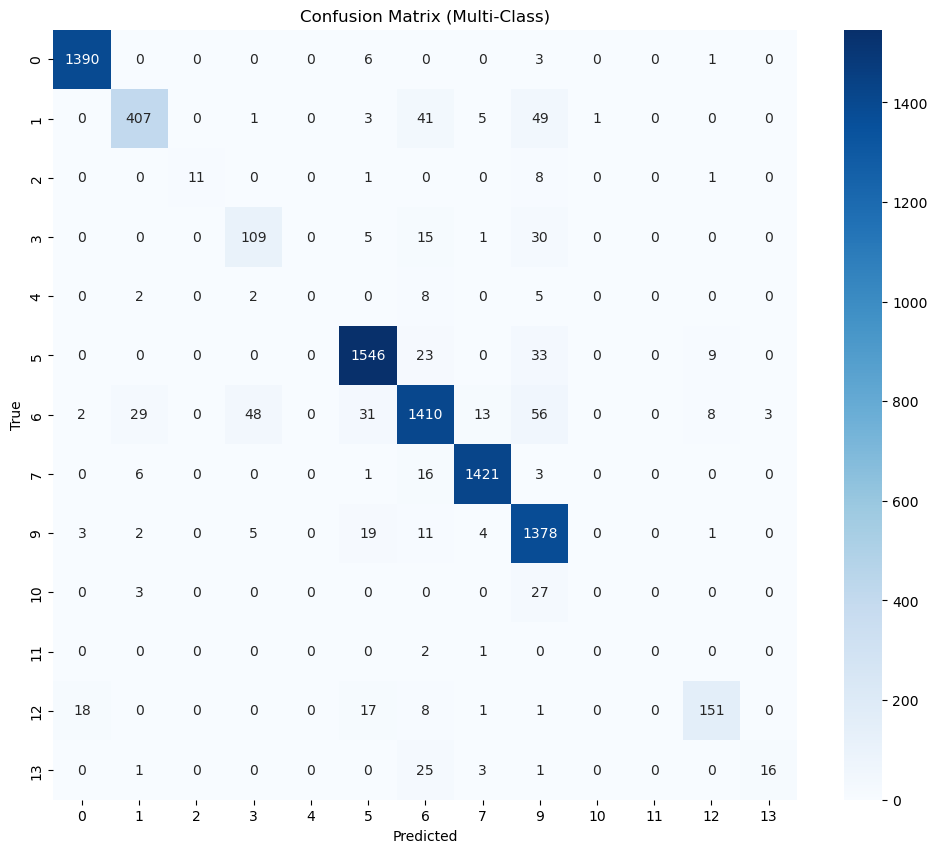

In [12]:
# Optional: Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
class_labels = list(range(14))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Multi-Class)')
plt.show()

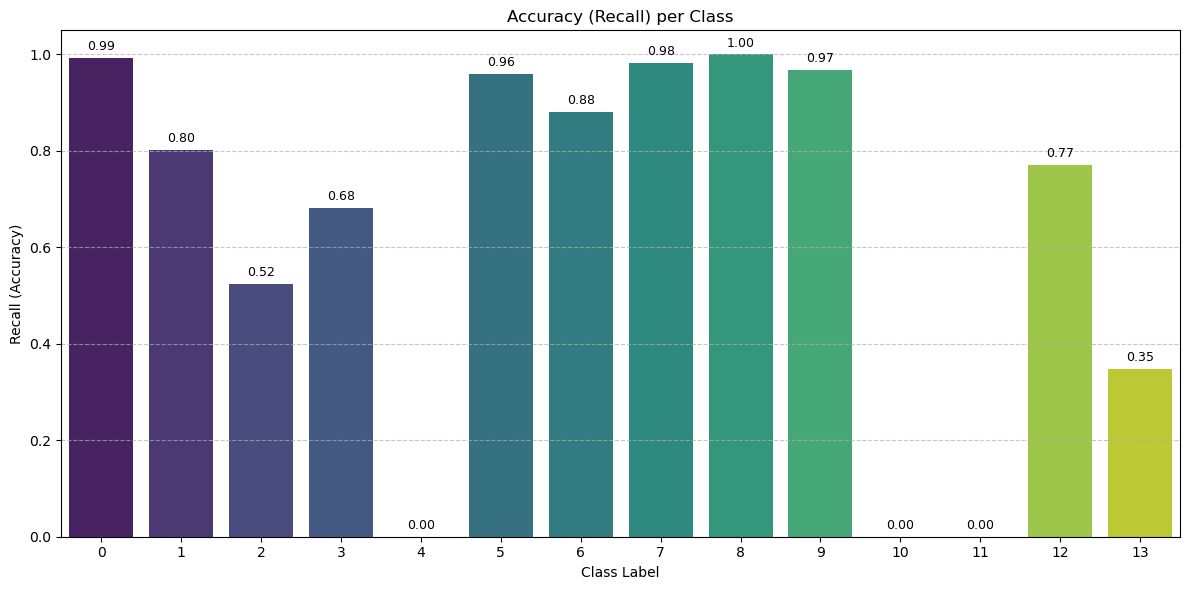

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Class labels (0–13)
class_labels = list(range(14))

# Recall values (from your classification report)
recall_per_class = [
    0.9929,  # class 0
    0.8028,  # class 1
    0.5238,  # class 2
    0.6813,  # class 3
    0.0000,  # class 4
    0.9597,  # class 5
    0.8812,  # class 6
    0.9820,  # class 7
    1.0000,  # class 8
    0.9684,  # class 9
    0.0000,  # class 10
    0.0000,  # class 11
    0.7704,  # class 12
    0.3478   # class 13
]

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=recall_per_class, palette='viridis')
plt.title('Accuracy (Recall) per Class')
plt.xlabel('Class Label')
plt.ylabel('Recall (Accuracy)')
plt.ylim(0.0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars
for i, rec in enumerate(recall_per_class):
    plt.text(i, rec + 0.01, f"{rec:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
